In [344]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using SparseArrays
using ForwardDiff
using OSQP
using RobotDynamics
using RobotZoo: PlanarRocket
using RobotZoo
using StaticArrays
using Plots
using JLD2
using Test
using Statistics

const FD = ForwardDiff;

include("quadrotor.jl");

  Activating environment at `C:\Users\jonbs\Documents\JonathanStuff\CMU_Stuff\year2\OCRL\Quadrotor_MPC_with_Kalman_Filter\Project.toml`


## Quadrotor Dynamics Model

The derivation of the 3d Quadrotor Dynamics model we use is available in [Lecture 15's Notes](https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%2015/Lecture%2015.pdf)

$$ 
x = \begin{bmatrix} {}^{N}r \\ q \\ {}^{B}V \\ {}^{B}\omega \end{bmatrix}, \quad
\dot{x} = 
\begin{bmatrix} 
    Q {}^{B}V \\
    \frac{1}{2} L(q) H {}^{B}\omega \\
    \frac{1}{m} {}^{B}F - {}^{B}\omega \times {}^{B}V \\
    J^{-1} ({}^{B}\tau - {}^{B}\omega \times J {}^{B}\omega)
\end{bmatrix}
$$

Where:
$$
{}^{B}F = Q^T
\begin{bmatrix}
0 \\ 0 \\ -mg
\end{bmatrix}
+ 
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    k_T & k_T & k_T & k_T
\end{bmatrix} u
$$

$$
{}^{B}\tau = 
\begin{bmatrix}
    0 & s k_T & 0 & -s k_T \\
    -s k_T & 0 & s k_T & 0 \\
    k_m & -k_m & k_m & -k_m
\end{bmatrix} u
$$

Note that a rotation matrix $Q$ can be obtained from a quaternion $q$ via:
$$ 
Q = R^T(q) L(q)
$$

Such that:
$$
\begin{bmatrix} 0 \\ {}^{N}x \end{bmatrix} = Q \begin{bmatrix} 0 \\ {}^{B}x \end{bmatrix}
$$

For more information on the quaternion math, check out `src/quaternions.jl`

The model is defined like so:
![quad_dyn](../media/quadrotor_dynamics_image.png)
![quad_dyn_axes](../media/quadrotor_dynamics_axes_definition.png)

# LQR Controller (baseline)

The LQR formulation we used is a simple linearlization of the system about hover (i.e. all thrust vectors point straight down and sum to counter gravity).

This linearization gives us the following approximation of the system's dynamics:

$$x_{t+1} = A x_{t} + B u_{t}$$

Where A is the state Jacobian and B is the input Jacobian:
$$A = \frac{\partial x_{t+1}}{\partial x_{t}}, \quad B = \frac{\partial x_{t+1}}{\partial u_{t}}$$

This works so long as the quadrotor stays close to the point its dynamics were linearized about.

In [345]:
include("quaternions.jl")
include("dynamics.jl")
include("LQR_controller.jl")

nx = 13
nu = 4
dt = 0.025
T = 5.0
N = Int(T / dt)

model = Quadrotor()

x0 = zeros(nx)
# x0[4:7] .= [  0.9045898, 0.1836784, -0.3379966, 0.1836784] # quat version of (10, 10, 10) [deg] euler angles
x0[4] = 1.0 # enforce unit-norm constraint on quat
uhover = fill(mass * g / nu, nu) 

Q = diagm(ones(nx-1))
# Q[1:3,1:3] .= 100.0*I(3)
# Q[4:6,4:6] .= 1e5*I(3)
R = diagm(ones(nu))

Uref = [copy(uhover) for i = 1:N-1];
tref = LinRange(0.0, T, N);

# x_dot = dynamics(x0, uhover)
A, B = dynamics_jacobians(x0, uhover, dt)
J_attitude = attitude_jacobian(x0)
Ã = J_attitude'*A*J_attitude
B̃ = J_attitude'*B
K_LQR = lqr(Ã, B̃, Q, R, tol=1e-3);

LQR converged in 97 iterations


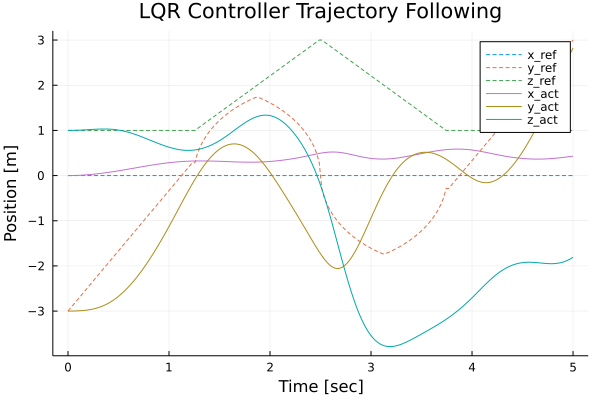

In [346]:
include("quadrotor.jl")
include("dynamics.jl")
X_LQR = [zeros(nx) for i = 1:N]
U_LQR = [copy(uhover) for i = 1:N-1]

# X_line = line_reference(N, dt)
X_line = flip_reference(N, dt)
X_LQR[1][1:4] .= X_line[1][1:4]
# println(X_LQR[1])
# X_LQR[1][4] = 1.0

vals_ref = zeros(N,3)
vals_ref[1,:] .= X_line[1][1:3]
vals_act = zeros(N,3)
vals_act[1,:] .= X_LQR[1][1:3]

for k = 1:N-1
    
    dϕ = ϕ(quat_L(X_line[k][4:7])' * X_LQR[k][4:7])
    dX = vcat([(X_LQR[k] - X_line[k])[1:3]' dϕ' (X_LQR[k] - X_line[k])[8:end]'])'
    
    U_LQR[k] .= U_LQR[k] - (K_LQR * dX)[:,1]
    X_LQR[k+1] .= rk4(X_LQR[k], U_LQR[k], dt)[:,1]
    
    vals_ref[k+1,:] .= X_line[k+1][1:3]
    vals_act[k+1,:] .= X_LQR[k+1][1:3]

end

plot(tref, vals_ref, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
plot!(tref, vals_act, label=["x_act" "y_act" "z_act"])

In [395]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8706
└ @ MeshCat C:\Users\jonbs\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8706))

In [397]:
include("quadrotor.jl");
# line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)
# visualize!(vis, model, dt*(N-1), flip_ref)
plot(tref, vals_act, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
visualize!(vis, model, dt*(N-1), X_LQR)

# MPC Controller

The MPC controller works by solving the following QP:
$$ \begin{align}
    &\text{minimize}_{z} && \frac{1}{2} z^T P z\\
    &\text{subject to} && D z = d \\
    &&& C z \leq d \\
\end{align} $$

where $z$ is the concatenated vector of changes in states and controls from the reference trajectory at each time step. Since we've linearized our system about the point $(x_\text{eq}, u_\text{eq})$, these state and controls are defined relative to this reference. The equality constraints are just the linearized dynamics constraints:

$$ 
\begin{bmatrix} 
    B_k & -I \\ 
      & A_{k+1} & B_{k+1} & -I \\
      &   &   &   & \ddots \\
      &   &   &   & & A_{k+N-1} & B_{k+N-1} -I \\
\end{bmatrix}
\begin{bmatrix} \Delta u_k \\ \Delta x_{k+1} \\ \Delta u_{k+1} \\ \vdots \\ \Delta x_{k+N-1} \\ \Delta u_{k+N-1} \\ \Delta x_{k+N} \end{bmatrix} = 
\begin{bmatrix} -A_k (x_k - x_{ref,k}) \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

And the inequality constraints limit the thrust the quadrotor can generate:

$$ 
\begin{bmatrix} u_{min} - u_k \\ u_{min} - u_{k+1} \\ \vdots \\ u_{min} - u_{k+N-1} \end{bmatrix} \leq 
\begin{bmatrix}
    I(m) \\
    0(n+m) & I(m) \\
    & 0(n+m) & I(m) \\
    &&& \ddots \\
    &&&& I(m) & 0(n)
\end{bmatrix}
\begin{bmatrix} \Delta u_k \\ \Delta x_{k+1} \\ \Delta u_{k+1} \\ \vdots \\ \Delta x_{k+N-1} \\ \Delta u_{k+N-1} \\ \Delta x_{k+N} \end{bmatrix} \leq 
\begin{bmatrix} u_{max} - u_k \\ u_{max} - u_{k+1} \\ \vdots \\ u_{max} - u_{k+N-1} \end{bmatrix}
$$

The cost matrix $P$ is defined as:
$$
P = \begin{bmatrix}
R \\
& Q \\
&& \ddots \\
&&& R \\
&&&& Q_f
\end{bmatrix}
$$

In [406]:
include("dynamics.jl")
include("quadrotor.jl")
include("quaternions.jl")

const n = state_dim(model)
const m = control_dim(model)

line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)
# flip_ref = simple_flip_reference(N, dt)

Uref = [copy(uhover) for i = 1:N]
umin = -5*uhover[1]
umax = 5*uhover[1]

A = []
B = []

for i=1:N
#     angle = angle_of_rotation_q(flip_ref[1][4:7])
#     thrust_des = uhover / cos(angle*2)
#     clamp!(thrust_des, umin, umax)
#     Uref[i] = thrust_des
    
    A_i, B_i = dynamics_jacobians(flip_ref[i],Uref[i],dt)
    J_attitude = attitude_jacobian(flip_ref[i])
    Ã_i = J_attitude'*A_i*J_attitude
    B̃_i = J_attitude'*B_i
    push!(A, Ã_i)
    push!(B, B̃_i)
    
end

In [407]:
include("MPC.jl")
include("quaternions.jl")

# note: lower Q value means controller will be less inclined to adjust those values away from ref traj
# ... maybe. I actually think it may be the opposite

Q = 1.0*I(nx-1)
# Q[1:3,1:3] *= 0.1
Q[4:7,4:7] *= 10 # attitude
# Q[1:2] *= 0.05 
# Q[8:end] *= 10 # vel and angular vel
# Q[11,11] *= 0.01 # x angular vel
R = 1e-5*I(nu)
Qf = 1.0*I(nx-1)
Qf[1:3,1:3] *= 1e-3
Nmpc = 50

x0 = zeros(nx)
for i=1:7
    x0[i] = flip_ref[1][i]
end


mpc = build_MPC_QP(flip_ref, Uref, tref, A, B, Q, R, Qf);
X_mpc,U_mpc,t_mpc = simulate(model, x0, mpc, A, B, tf=T, wind_disturbance=false);

Controller ran at 51.83094889909388 Hz


In [402]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8707
└ @ MeshCat C:\Users\jonbs\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8707))

In [409]:
visualize!(vis, model, dt*(N-1), X_mpc)
# visualize!(vis, model, dt*(N-1), flip_ref)

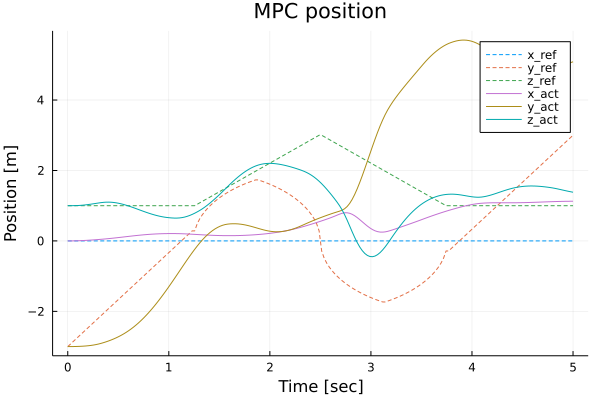

In [357]:
include("plotter.jl")
labs = ["x", "y", "z"]
indices = 1:3
plot_vals(flip_ref, X_mpc, indices, labs, "MPC position")

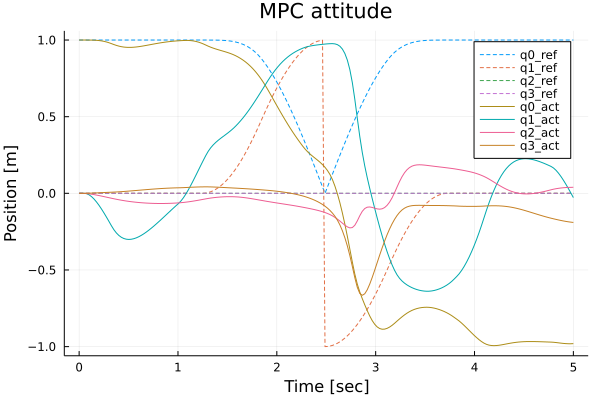

In [358]:
labs = ["q0", "q1", "q2", "q3"]
indices = 4:7
plot_vals(flip_ref, X_mpc, indices, labs, "MPC attitude")

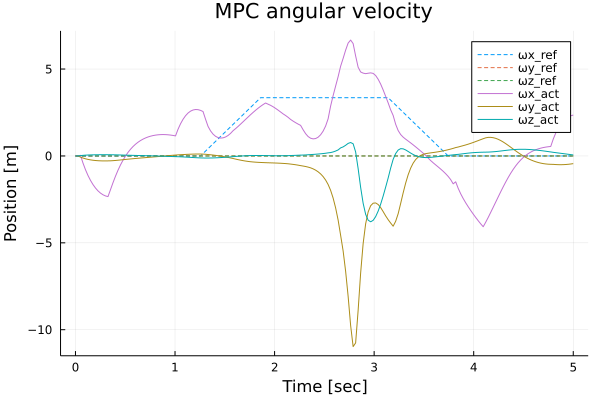

In [355]:
labs = ["ωx", "ωy", "ωz"]
indices = 11:13
plot_vals(flip_ref, X_mpc, indices, labs, "MPC angular velocity")

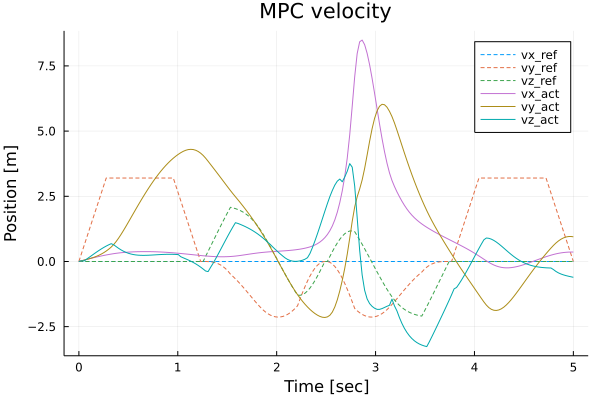

In [356]:
labs = ["vx", "vy", "vz"]
indices = 8:10
plot_vals(flip_ref, X_mpc, indices, labs, "MPC velocity")